In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42)    # keep random so we get the same values

In [2]:
print(f"First 5 X features: {X[:5]}")
print(f"First 5 y labels: {y[:5]}")

First 5 X features: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y labels: [1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

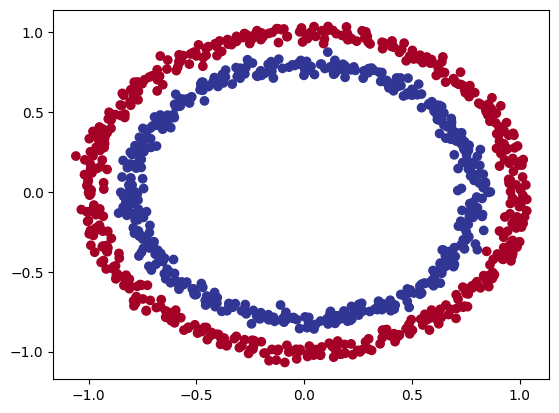

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
import torch
from torch import nn

device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and outputs 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features and outputs 1

    # 3. Define the forward method containing the forward pass computation
    def forward(self, x):
        return self.layer_2(self.layer_1(x))    # compuation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Replicate CricleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"First 10 actual values: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions: tensor([[-0.8189],
        [-0.9793],
        [-0.3892],
        [-0.9407],
        [-0.3746],
        [-0.4726],
        [-0.9359],
        [-0.8172],
        [-0.3904],
        [-0.9899]], device='mps:0', grad_fn=<SliceBackward0>)
First 10 actual values: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
# Create a loss function
# loss_fun = nn.BCELoss()   # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()    # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.8189],
        [-0.9793],
        [-0.3892],
        [-0.9407],
        [-0.3746]], device='mps:0', grad_fn=<SliceBackward0>)

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3060],
        [0.2730],
        [0.4039],
        [0.2808],
        [0.4074]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [18]:
# Find the predicted labels (round the prediction probabilites)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 0., 0., 0.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [20]:
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()   # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits))   # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train)    # BCEWithLogitsLoss doesn't require sigmoid layer
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5.Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 0.74758 | Train Acc: 50.00 | Test Loss: 0.73576 | Test Acc: 50.00
Epoch: 10 | Train Loss: 0.71470 | Train Acc: 50.00 | Test Loss: 0.70640 | Test Acc: 50.00
Epoch: 20 | Train Loss: 0.70266 | Train Acc: 41.62 | Test Loss: 0.69626 | Test Acc: 42.00
Epoch: 30 | Train Loss: 0.69796 | Train Acc: 45.25 | Test Loss: 0.69279 | Test Acc: 51.50
Epoch: 40 | Train Loss: 0.69596 | Train Acc: 46.50 | Test Loss: 0.69169 | Test Acc: 52.00
Epoch: 50 | Train Loss: 0.69500 | Train Acc: 47.88 | Test Loss: 0.69143 | Test Acc: 52.00
Epoch: 60 | Train Loss: 0.69447 | Train Acc: 48.50 | Test Loss: 0.69147 | Test Acc: 53.50
Epoch: 70 | Train Loss: 0.69413 | Train Acc: 49.12 | Test Loss: 0.69162 | Test Acc: 53.50
Epoch: 80 | Train Loss: 0.69389 | Train Acc: 49.62 | Test Loss: 0.69180 | Test Acc: 52.00
Epoch: 90 | Train Loss: 0.69371 | Train Acc: 49.25 | Test Loss: 0.69199 | Test Acc: 52.50


In [21]:
import requests
from pathlib import Path

# Download the helper function script
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_functions.py...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "w") as file:
        file.write(request.text)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download...


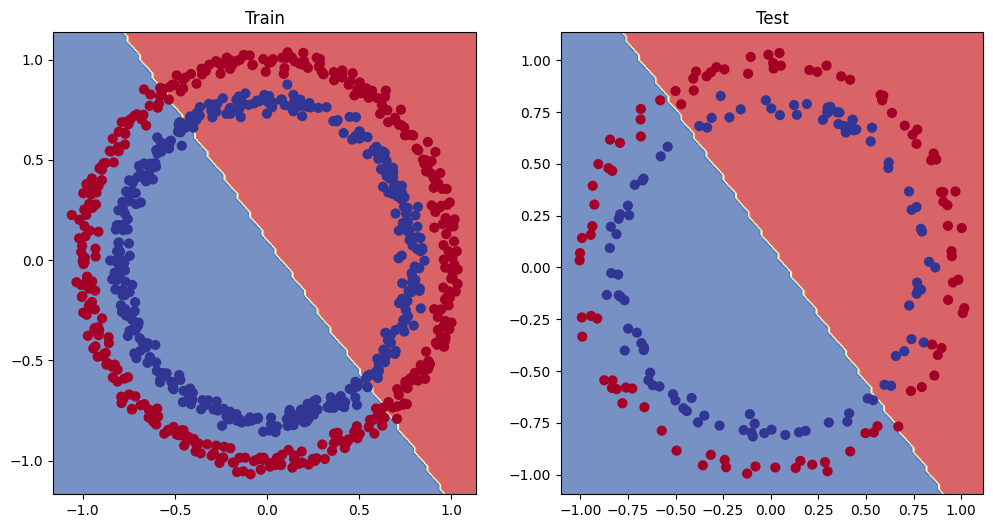

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X=X_test, y=y_test)

In [23]:
class CirclemodelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):   # note: always make sure forward is spelt correctly
        # Creating a module like this is the same as below, though below
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CirclemodelV1().to(device)
model_1

CirclemodelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
# loss_fn = nn.BCELoss()    # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss()    # Doesn't require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000   # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))   # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 0.69396 | Train Acc: 50.88 | Test Loss: 0.69261 | Test Acc: 51.00
Epoch: 100 | Train Loss: 0.69305 | Train Acc: 50.38 | Test Loss: 0.69379 | Test Acc: 48.00
Epoch: 200 | Train Loss: 0.69299 | Train Acc: 51.12 | Test Loss: 0.69437 | Test Acc: 46.00
Epoch: 300 | Train Loss: 0.69298 | Train Acc: 51.62 | Test Loss: 0.69458 | Test Acc: 45.00
Epoch: 400 | Train Loss: 0.69298 | Train Acc: 51.12 | Test Loss: 0.69465 | Test Acc: 46.00
Epoch: 500 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69467 | Test Acc: 46.00
Epoch: 600 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00
Epoch: 700 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00
Epoch: 800 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00
Epoch: 900 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00


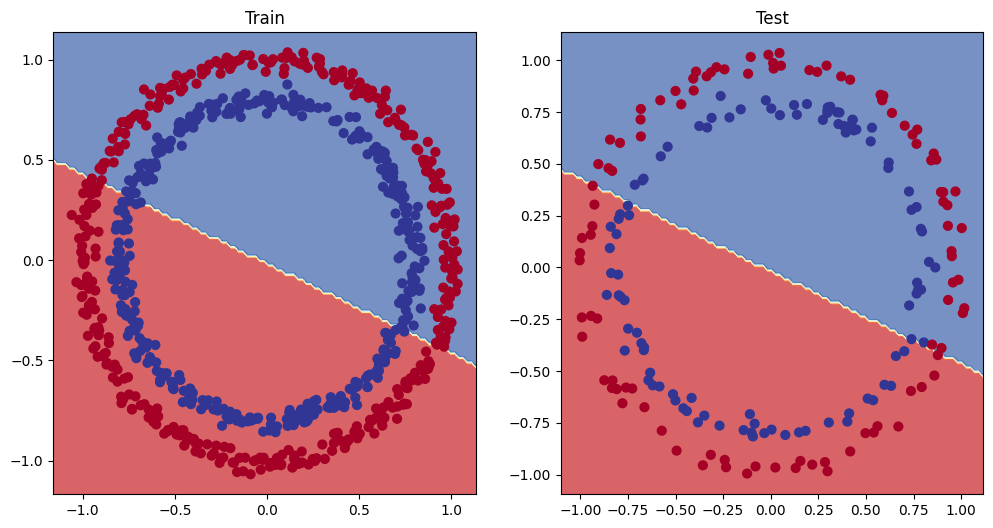

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X=X_test, y=y_test)

In [27]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))  # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression))

80 80 20 20


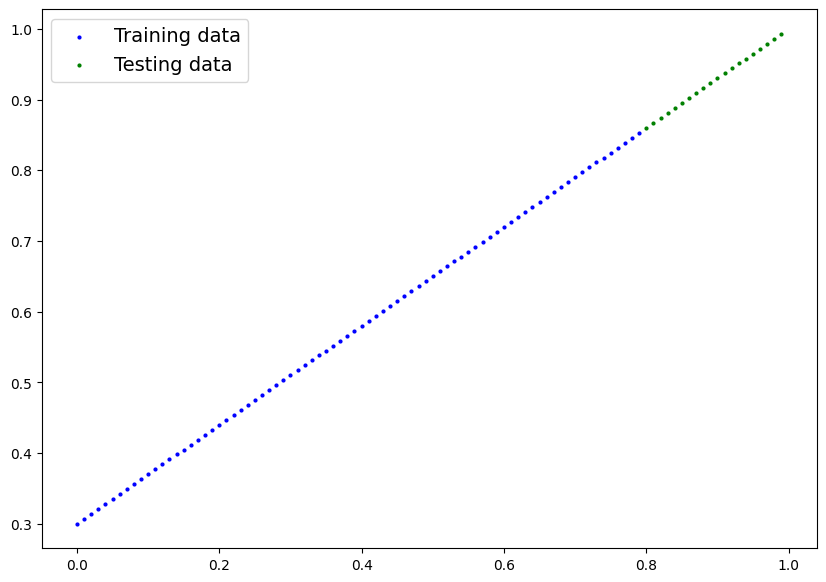

In [29]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [30]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
loss_fn = nn.L1Loss()    # L1Loss for regression
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [32]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)

    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_2.eval()
    with torch.inference_mode():
        test_loss = loss_fn(model_2(X_test_regression), y_test_regression)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.75986 | Test Loss: 0.54143
Epoch: 100 | Train Loss: 0.09309 | Test Loss: 0.02901
Epoch: 200 | Train Loss: 0.07376 | Test Loss: 0.02850
Epoch: 300 | Train Loss: 0.06745 | Test Loss: 0.00615
Epoch: 400 | Train Loss: 0.06107 | Test Loss: 0.02004
Epoch: 500 | Train Loss: 0.05698 | Test Loss: 0.01061
Epoch: 600 | Train Loss: 0.04857 | Test Loss: 0.01326
Epoch: 700 | Train Loss: 0.06109 | Test Loss: 0.02127
Epoch: 800 | Train Loss: 0.05599 | Test Loss: 0.01426
Epoch: 900 | Train Loss: 0.05571 | Test Loss: 0.00603


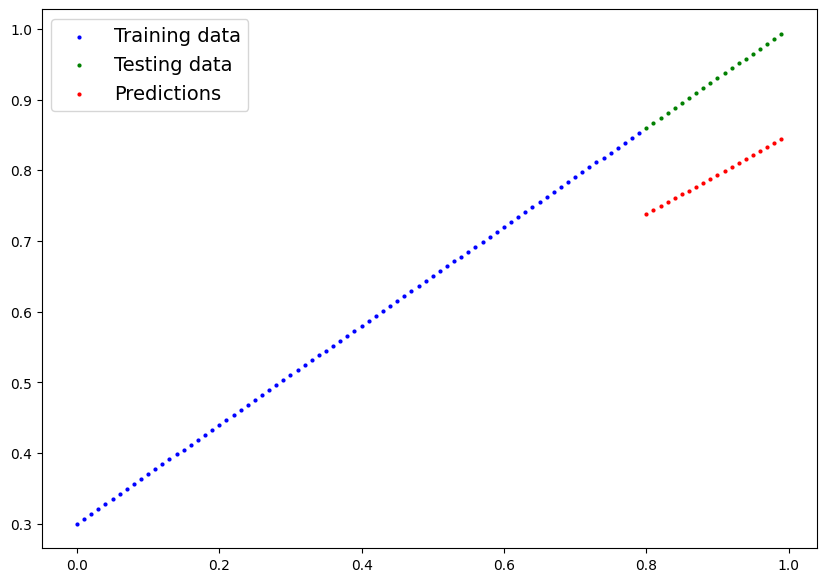

In [33]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu()
)

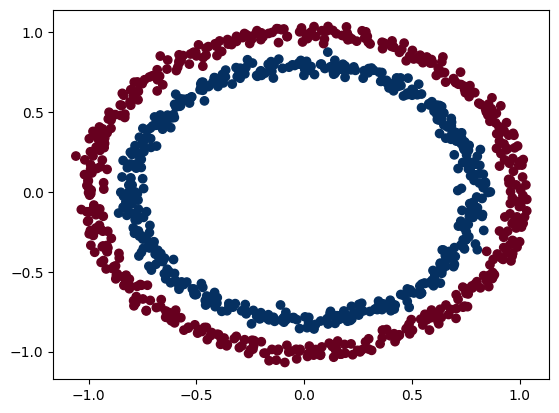

In [34]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [35]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [36]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()   # <- add in ReLU activation function
        # Can also put sigmoid here in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # intersperse the ReLU activation function between the layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [37]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.1)

In [38]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 0.69295 | Train Acc: 50.00 | Test Loss: 0.69394 | Test Acc: 50.00
Epoch: 100 | Train Loss: 0.00168 | Train Acc: 100.00 | Test Loss: 0.00744 | Test Acc: 100.00
Epoch: 200 | Train Loss: 0.00071 | Train Acc: 100.00 | Test Loss: 0.00543 | Test Acc: 100.00
Epoch: 300 | Train Loss: 0.00041 | Train Acc: 100.00 | Test Loss: 0.00493 | Test Acc: 100.00
Epoch: 400 | Train Loss: 0.00026 | Train Acc: 100.00 | Test Loss: 0.00573 | Test Acc: 100.00
Epoch: 500 | Train Loss: 0.00018 | Train Acc: 100.00 | Test Loss: 0.00516 | Test Acc: 100.00
Epoch: 600 | Train Loss: 0.00013 | Train Acc: 100.00 | Test Loss: 0.00513 | Test Acc: 100.00
Epoch: 700 | Train Loss: 0.00010 | Train Acc: 100.00 | Test Loss: 0.00534 | Test Acc: 100.00
Epoch: 800 | Train Loss: 0.00008 | Train Acc: 100.00 | Test Loss: 0.00560 | Test Acc: 100.00
Epoch: 900 | Train Loss: 0.00007 | Train Acc: 100.00 | Test Loss: 0.00577 | Test Acc: 100.00


In [39]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

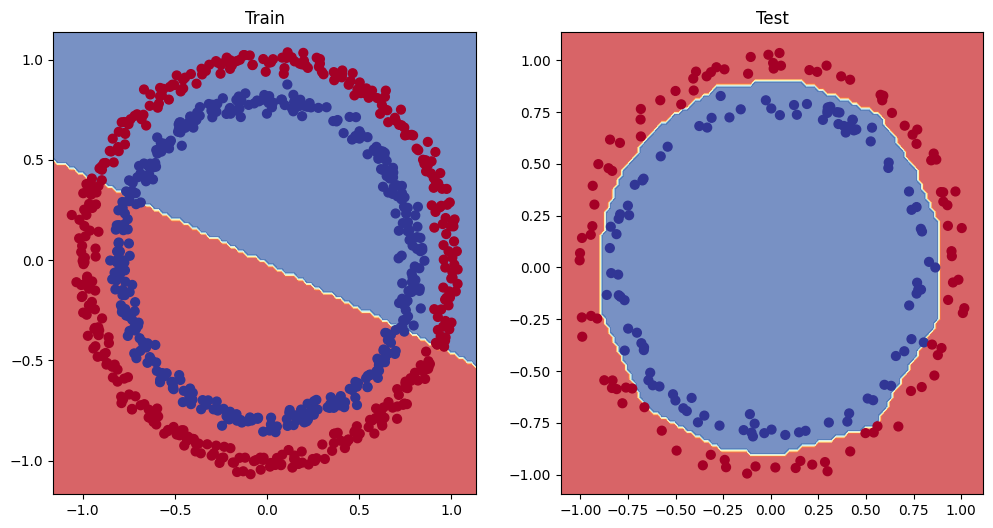

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X=X_test, y=y_test)

In [41]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

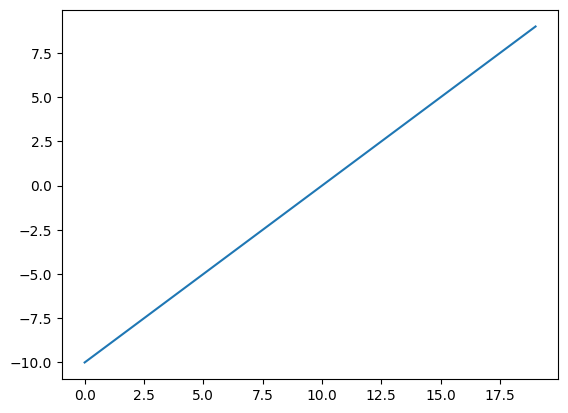

In [42]:
plt.plot(A)

In [43]:
def relu(x):
    return torch.maximum(x, torch.tensor(0.0))

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

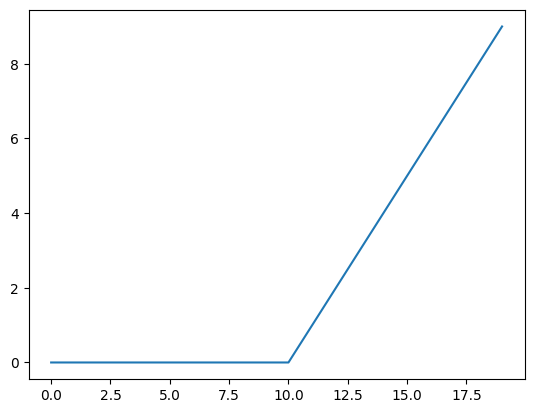

In [44]:
plt.plot(relu(A))

In [45]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

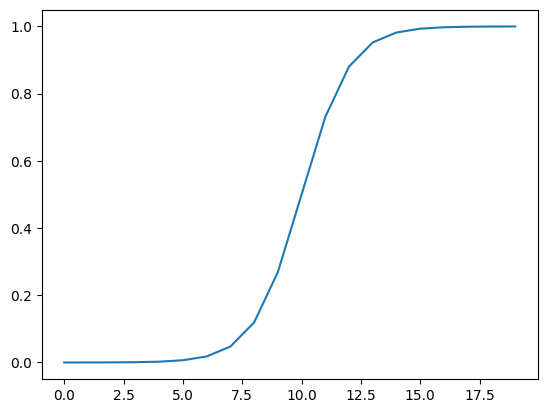

In [46]:
plt.plot(sigmoid(A))

tensor([[-8.5550,  7.0646],
        [-6.1375, -6.5808],
        [-6.3213, -6.8041],
        [ 4.1805,  1.1233],
        [ 4.3803,  0.4700]]) tensor([3, 2, 2, 1, 1])


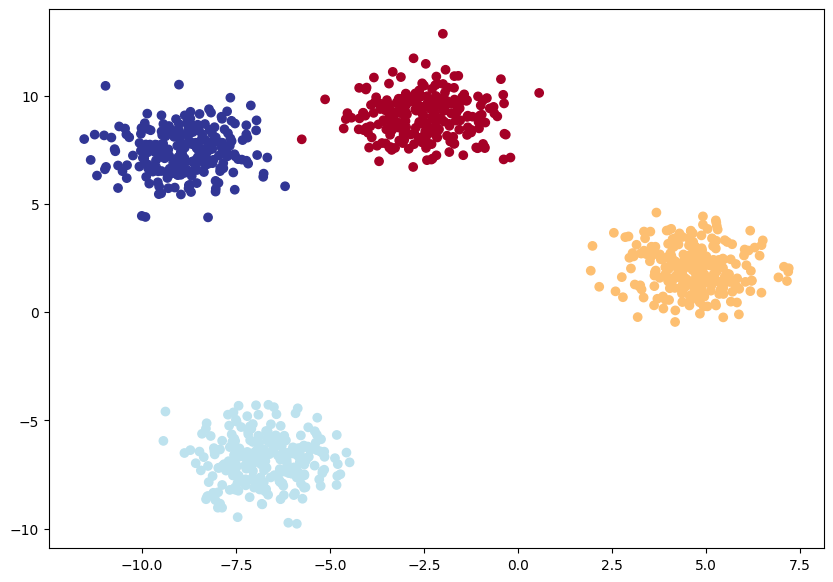

In [47]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [48]:
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [49]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4
        

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [50]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [51]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2096, -0.5905, -1.3977, -0.6999],
        [ 0.2225, -1.5206,  0.0469,  1.1367],
        [ 2.6882,  0.8213,  3.1033,  1.3287],
        [ 2.0801,  0.4201,  2.3750,  1.1485],
        [ 0.4390, -1.3168,  0.3150,  1.1549]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [52]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [53]:
y_logits = model_4(X_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2341, -0.3357,  0.2307,  0.2534],
        [ 0.1198, -0.3702,  0.0998,  0.1887],
        [ 0.3790, -0.2037,  0.4095,  0.2689],
        [ 0.1936, -0.3733,  0.1807,  0.2496],
        [ 0.1338, -0.1378,  0.1487,  0.0247]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2792, 0.1579, 0.2782, 0.2846],
        [0.2729, 0.1672, 0.2675, 0.2924],
        [0.2869, 0.1602, 0.2958, 0.2570],
        [0.2769, 0.1571, 0.2733, 0.2928],
        [0.2722, 0.2075, 0.2763, 0.2441]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [54]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='mps:0', grad_fn=<SumBackward0>)

In [55]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2792, 0.1579, 0.2782, 0.2846], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='mps:0')


In [56]:
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 1.03702 | Train Acc: 68.50 | Test Loss: 0.56405 | Test Acc: 99.00
Epoch: 10 | Train Loss: 0.11087 | Train Acc: 99.88 | Test Loss: 0.10004 | Test Acc: 100.00
Epoch: 20 | Train Loss: 0.04924 | Train Acc: 99.88 | Test Loss: 0.04515 | Test Acc: 100.00
Epoch: 30 | Train Loss: 0.03032 | Train Acc: 99.88 | Test Loss: 0.02747 | Test Acc: 100.00
Epoch: 40 | Train Loss: 0.02171 | Train Acc: 99.88 | Test Loss: 0.01930 | Test Acc: 100.00
Epoch: 50 | Train Loss: 0.01691 | Train Acc: 99.88 | Test Loss: 0.01471 | Test Acc: 100.00
Epoch: 60 | Train Loss: 0.01389 | Train Acc: 99.88 | Test Loss: 0.01182 | Test Acc: 100.00
Epoch: 70 | Train Loss: 0.01182 | Train Acc: 99.88 | Test Loss: 0.00985 | Test Acc: 100.00
Epoch: 80 | Train Loss: 0.01033 | Train Acc: 99.88 | Test Loss: 0.00843 | Test Acc: 100.00
Epoch: 90 | Train Loss: 0.00920 | Train Acc: 99.88 | Test Loss: 0.00736 | Test Acc: 100.00


In [58]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[  3.7826,   9.6491, -13.3451,  -9.3730],
        [  4.6158, -11.4566,   3.4186,  10.4919],
        [ -5.3788, -13.3182,  20.4723,  13.1327],
        [  2.1570,   7.7691,  -9.2223,  -7.4535],
        [  7.4186,   2.1213, -12.5310,  -2.5824],
        [  4.9372, -13.2517,   4.4570,  12.1594],
        [ -5.5794, -11.3640,  19.1111,  11.3043],
        [  6.7285,  -0.4670,  -9.2496,  -0.0764],
        [ -5.4545, -16.6079,  23.4032,  16.2472],
        [  6.9009,   0.4720, -10.3194,  -0.9787]], device='mps:0')

In [59]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_blob_test, y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Test accuracy: 100.0%


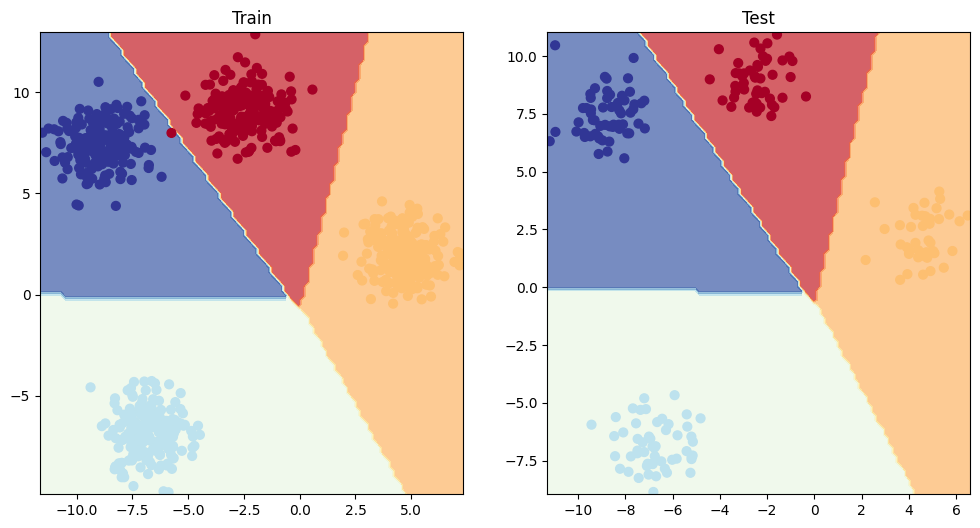

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X=X_blob_train, y=y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X=X_blob_test, y=y_blob_test)

In [90]:
from torchmetrics import Accuracy
from typing import Literal

# print(torch.unique(y_blob_test))

torchmetrics_accury = Accuracy(task='multiclass', num_classes=4).to(device)
acc = torchmetrics_accury(y_preds, y_blob_test)
print(f"Accuracy: {acc.item()}")

Accuracy: 1.0
